In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras import optimizers

# Prepare Data

In [2]:
def preparedata(file):
    cloud_cover = pd.read_csv(file, skipinitialspace = True)
    cloud_cover['Date'] = cloud_cover[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
    cloud_cover['Time'] = cloud_cover[['Hour', 'Minute']].apply(lambda x: "{}:{}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
    cloud_cover.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)  
    cloud_cover = cloud_cover.rename(columns={"CloudCover":"cloud_cover"})
    cloud_cover = cloud_cover.groupby(['Date', 'Time']).agg(cloud_cover=('cloud_cover','mean')).reset_index()
    cloud_cover['DateTime'] = cloud_cover[['Date', 'Time']].apply(lambda x: "{} {}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
    cloud_cover.drop(["Date", "Time"], axis=1, inplace=True)        
    cloud_cover['DateTime'] = pd.to_datetime(cloud_cover['DateTime'], format="%Y-%m-%d %H:%M")
    cloud_cover.dropna(inplace=True)
    return cloud_cover
cloud_cover = preparedata('../succeed-prophet/Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv')
cloud_cover


cloud_cover            DateTime
0         0.990000 2021-11-16 11:15:00
1         0.989000 2021-11-16 11:16:00
2         0.987667 2021-11-16 11:17:00
3         0.987000 2021-11-16 11:18:00
4         0.987000 2021-11-16 11:19:00
...            ...                 ...
15056     0.168000 2021-12-16 13:58:00
15057     0.169000 2021-12-16 13:59:00
15058     0.147000 2021-12-16 14:00:00
15059     0.145000 2021-12-16 14:01:00
15060     0.144000 2021-12-16 14:02:00

[15061 rows x 2 columns]

In [3]:
def lags_train_test(data, lags):
	X, y = [], []
	for i in range(lags, len(data)):
		X.append(data[i-lags:i])
		y.append(data[i])
	return np.array(X), np.array(y)

In [4]:
def Xtrain_ytrain(train,test,lags):
    #scale train
    sc = MinMaxScaler()
    sc.fit(train)
    train_set_scale = sc.transform(train)
    # train
    X_train, y_train = lags_train_test(train_set_scale, lags)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    print("X_train Shape :", X_train.shape)
    print("y_train Shape :", y_train.shape)

    #scale test
    dataset_total = pd.concat((train['cloud_cover'], test['cloud_cover']), axis=0)
    inputs = dataset_total[len(dataset_total) - len(test) - lags:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    # test
    X_test, y_test = lags_train_test(inputs, lags)
    print("X_test Shape : ", X_test.shape)
    print("y_test Shape : ", y_test.shape)
    return X_train, y_train, X_test, y_test, sc

In [5]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [6]:
def plot_curve(history):
    # loss curves
    fig1 = plt.figure(figsize=[8,6])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'orange', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [7]:
def plot_test(train,pred):
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(mode = 'lines', x = train['DateTime'], y = train['cloud_cover'], name = 'Train'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['cloud_cover'], name = 'Actual'))
    fig2.add_trace(go.Scatter(mode = 'lines', x = pred['DateTime'], y = pred['LSTM'], name = 'Predict'))
    fig2.update_layout(
    autosize=True,
    height=600,
    title="LSTM Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
    )


    fig2.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=2,
                        label="2.zoom",
                        step="hour",
                        stepmode="backward"),
                    dict(count=3,
                        label="3.zoom",
                        step="day",
                        stepmode="backward"),              

                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig2.show()

# Train/Test Model

In [8]:
train,test = train_test_split(cloud_cover, train_size=0.8, shuffle=False)
print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (12048, 2)
Test Shape (3013, 2)


In [9]:
train

cloud_cover            DateTime
0         0.990000 2021-11-16 11:15:00
1         0.989000 2021-11-16 11:16:00
2         0.987667 2021-11-16 11:17:00
3         0.987000 2021-11-16 11:18:00
4         0.987000 2021-11-16 11:19:00
...            ...                 ...
12043     0.647000 2021-12-10 15:19:00
12044     0.654000 2021-12-10 15:20:00
12045     0.654000 2021-12-10 15:21:00
12046     0.578000 2021-12-10 15:22:00
12047     0.555000 2021-12-10 15:23:00

[12048 rows x 2 columns]

In [10]:
train = train.set_index('DateTime')
test = test.set_index('DateTime')

## Lag 5

In [11]:
# X_train, y_train, X_test and y_test
X_train, y_train, X_test, y_test, sc = Xtrain_ytrain(train,test,5)

X_train Shape : (12043, 5, 1)
y_train Shape : (12043, 1)
X_test Shape :  (3013, 5, 1)
y_test Shape :  (3013, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


### Optimizer adam batch size 32 units 100 second layer 100 epochs 10 

In [12]:
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(LSTM(units = 100))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [13]:
hist = regressor.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, batch_size = 32)

Epoch 1/10
377/377 [==============================] - 10s 14ms/step - loss: 0.0102 - val_loss: 0.0038
Epoch 2/10
377/377 [==============================] - 4s 10ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 3/10
377/377 [==============================] - 4s 10ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 4/10
377/377 [==============================] - 4s 10ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 5/10
377/377 [==============================] - 4s 10ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 6/10
377/377 [==============================] - 4s 10ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 7/10
377/377 [==============================] - 4s 10ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 8/10
377/377 [==============================] - 4s 10ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 9/10
377/377 [==============================] - 4s 10ms/step - loss: 9.9833e-04 - val_loss: 0.0020
Epoch 10/10
377/377 [==============================] - 4s 11ms/step - loss: 9.8924e-04

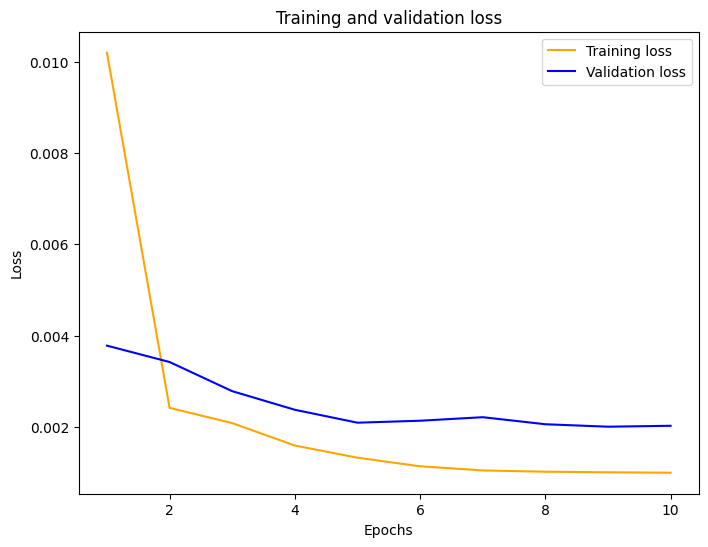

In [14]:
plot_curve(hist)

In [15]:
predict_scaled = regressor.predict(X_test)
predict = sc.inverse_transform(predict_scaled)
predict

95/95 [==============================] - 2s 5ms/step


array([[0.5505267 ],
       [0.5337574 ],
       [0.5865049 ],
       ...,
       [0.16736335],
       [0.14780577],
       [0.14366855]], dtype=float32)

In [16]:
train0 = train.copy()
test0 = test.copy()

In [17]:
train0.reset_index(inplace=True)
test0.reset_index(inplace=True)

In [18]:
test0['LSTM'] = predict
test0

DateTime  cloud_cover      LSTM
0    2021-12-10 15:24:00        0.538  0.550527
1    2021-12-10 15:25:00        0.588  0.533757
2    2021-12-10 15:26:00        0.566  0.586505
3    2021-12-10 15:27:00        0.562  0.560624
4    2021-12-10 15:28:00        0.612  0.557862
...                  ...          ...       ...
3008 2021-12-16 13:58:00        0.168  0.166678
3009 2021-12-16 13:59:00        0.169  0.166467
3010 2021-12-16 14:00:00        0.147  0.167363
3011 2021-12-16 14:01:00        0.145  0.147806
3012 2021-12-16 14:02:00        0.144  0.143669

[3013 rows x 3 columns]

In [19]:
plot_test(train0,test0)

In [20]:
lstm_mse_error = mean_squared_error(test0['cloud_cover'], test0['LSTM'], squared=True)
print(f'MSE Error of lags 5 : {lstm_mse_error}')

MSE Error of lags 5 : 0.002008920913432264


---

## Lag 10

In [21]:
# X_train, y_train, X_test and y_test
X_train1, y_train1, X_test1, y_test1, sc1 = Xtrain_ytrain(train,test,10)

X_train Shape : (12038, 10, 1)
y_train Shape : (12038, 1)
X_test Shape :  (3013, 10, 1)
y_test Shape :  (3013, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



### Optimizer adam first layer 50 batch size 32 learning rate 0.05 epochs 10

In [22]:
regressor1 = Sequential()
regressor1.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train1.shape[1], 1)))
regressor1.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.05)
regressor1.compile(optimizer = opt, loss = 'mean_squared_error')

In [23]:
hist1 = regressor1.fit(X_train1, y_train1, validation_data=(X_test1, y_test1), epochs = 10, batch_size = 32)

Epoch 1/10
377/377 [==============================] - 7s 10ms/step - loss: 0.1867 - val_loss: 0.0833
Epoch 2/10
377/377 [==============================] - 2s 6ms/step - loss: 0.0432 - val_loss: 0.0035
Epoch 3/10
377/377 [==============================] - 2s 5ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 4/10
377/377 [==============================] - 2s 6ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 5/10
377/377 [==============================] - 2s 6ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 6/10
377/377 [==============================] - 2s 6ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 7/10
377/377 [==============================] - 2s 6ms/step - loss: 0.0027 - val_loss: 0.0049
Epoch 8/10
377/377 [==============================] - 2s 6ms/step - loss: 0.0023 - val_loss: 0.0052
Epoch 9/10
377/377 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 10/10
377/377 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.003

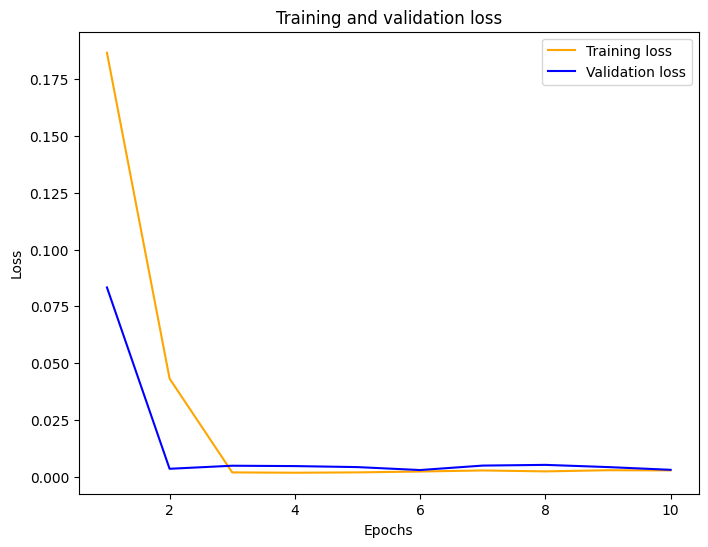

In [24]:
plot_curve(hist1)

In [25]:
predict_scaled1 = regressor1.predict(X_test1)
predict1 = sc1.inverse_transform(predict_scaled1)

95/95 [==============================] - 1s 3ms/step


In [26]:
test1 = test.copy()
train1 = train.copy()

In [27]:
train1.reset_index(inplace=True)
test1.reset_index(inplace=True)

In [28]:
test1['LSTM'] = predict1
test1

DateTime  cloud_cover      LSTM
0    2021-12-10 15:24:00        0.538  0.561198
1    2021-12-10 15:25:00        0.588  0.519163
2    2021-12-10 15:26:00        0.566  0.624343
3    2021-12-10 15:27:00        0.562  0.534793
4    2021-12-10 15:28:00        0.612  0.573382
...                  ...          ...       ...
3008 2021-12-16 13:58:00        0.168  0.147254
3009 2021-12-16 13:59:00        0.169  0.148252
3010 2021-12-16 14:00:00        0.147  0.149073
3011 2021-12-16 14:01:00        0.145  0.123922
3012 2021-12-16 14:02:00        0.144  0.130009

[3013 rows x 3 columns]

In [29]:
plot_test(train1,test1)

In [30]:
lstm_mse_error1 = mean_squared_error(test1['cloud_cover'], test1['LSTM'], squared=True)
print(f'MSE Error of lags 10 : {lstm_mse_error1}')

MSE Error of lags 10 : 0.003002537490876581


---

## Lag 15

In [31]:
# X_train, y_train, X_test and y_test
X_train2, y_train2, X_test2, y_test2, sc2 = Xtrain_ytrain(train,test,15)

X_train Shape : (12033, 15, 1)
y_train Shape : (12033, 1)
X_test Shape :  (3013, 15, 1)
y_test Shape :  (3013, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



### Optimizer adam batch size 32 units 100 second layer 100 epochs 10 

In [32]:
regressor2 = Sequential()
regressor2.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train2.shape[1], 1)))
regressor2.add(Dense(units = 1))
regressor2.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [33]:
hist2 = regressor2.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), epochs = 10, batch_size = 32)

Epoch 1/10
377/377 [==============================] - 8s 13ms/step - loss: 0.0069 - val_loss: 0.0037
Epoch 2/10
377/377 [==============================] - 5s 14ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 3/10
377/377 [==============================] - 5s 12ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 4/10
377/377 [==============================] - 4s 11ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 5/10
377/377 [==============================] - 4s 11ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 6/10
377/377 [==============================] - 4s 11ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 7/10
377/377 [==============================] - 4s 11ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 8/10
377/377 [==============================] - 5s 13ms/step - loss: 9.9325e-04 - val_loss: 0.0021
Epoch 9/10
377/377 [==============================] - 6s 15ms/step - loss: 9.6472e-04 - val_loss: 0.0023
Epoch 10/10
377/377 [==============================] - 6s 15ms/step - loss: 9.6908e

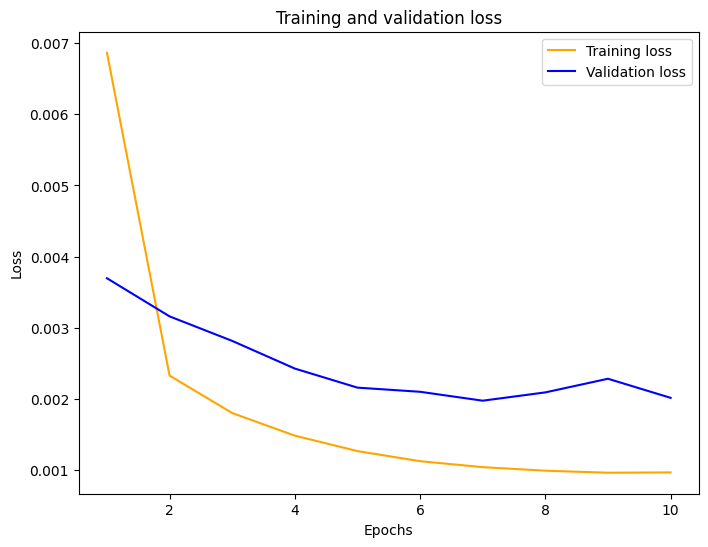

In [34]:
plot_curve(hist2)

In [35]:
predict_scaled2 = regressor2.predict(X_test2)
predict2 = sc2.inverse_transform(predict_scaled2)

95/95 [==============================] - 1s 6ms/step


In [36]:
train2 = train.copy()
test2 = test.copy()

In [37]:
train2.reset_index(inplace=True)
test2.reset_index(inplace=True)

In [38]:
test2['LSTM'] = predict2
test2

DateTime  cloud_cover      LSTM
0    2021-12-10 15:24:00        0.538  0.557285
1    2021-12-10 15:25:00        0.588  0.540645
2    2021-12-10 15:26:00        0.566  0.590156
3    2021-12-10 15:27:00        0.562  0.569069
4    2021-12-10 15:28:00        0.612  0.564442
...                  ...          ...       ...
3008 2021-12-16 13:58:00        0.168  0.171753
3009 2021-12-16 13:59:00        0.169  0.171534
3010 2021-12-16 14:00:00        0.147  0.172437
3011 2021-12-16 14:01:00        0.145  0.152928
3012 2021-12-16 14:02:00        0.144  0.148490

[3013 rows x 3 columns]

In [39]:
plot_test(train2,test2)

In [40]:
lstm_mse_error2 = mean_squared_error(test2['cloud_cover'], test2['LSTM'], squared=True)
print(f'MSE Error of lags 15 : {lstm_mse_error2}')

MSE Error of lags 15 : 0.0020065670800072013


---

## Lag 20

In [41]:
# X_train, y_train, X_test and y_test
X_train3, y_train3, X_test3, y_test3, sc3 = Xtrain_ytrain(train,test,20)

X_train Shape : (12028, 20, 1)
y_train Shape : (12028, 1)
X_test Shape :  (3013, 20, 1)
y_test Shape :  (3013, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



### Optimizer adam first layer 50 batch size 32 learning rate 0.005 epochs 10 

In [42]:
regressor3 = Sequential()
regressor3.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train3.shape[1], 1)))
regressor3.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
regressor3.compile(optimizer = opt, loss = 'mean_squared_error')

In [43]:
hist3 = regressor3.fit(X_train3, y_train3, validation_data=(X_test3, y_test3), epochs = 10, batch_size = 32)

Epoch 1/10
376/376 [==============================] - 7s 11ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 2/10
376/376 [==============================] - 4s 9ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 3/10
376/376 [==============================] - 4s 10ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 4/10
376/376 [==============================] - 4s 9ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 5/10
376/376 [==============================] - 4s 9ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 6/10
376/376 [==============================] - 3s 9ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 7/10
376/376 [==============================] - 4s 10ms/step - loss: 9.8967e-04 - val_loss: 0.0021
Epoch 8/10
376/376 [==============================] - 3s 9ms/step - loss: 9.9734e-04 - val_loss: 0.0022
Epoch 9/10
376/376 [==============================] - 4s 10ms/step - loss: 9.9614e-04 - val_loss: 0.0020
Epoch 10/10
376/376 [==============================] - 4s 9ms/step - loss: 0.0010 - 

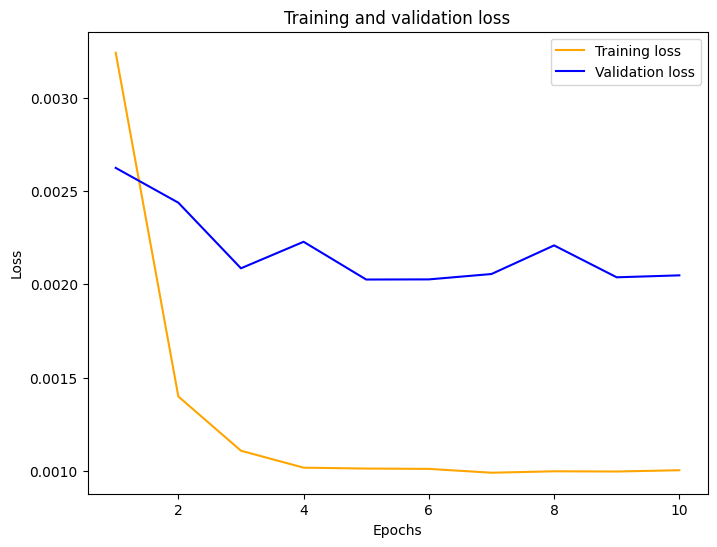

In [44]:
plot_curve(hist3)

In [45]:
predict_scaled3 = regressor3.predict(X_test3)
predict3 = sc3.inverse_transform(predict_scaled3)

95/95 [==============================] - 1s 3ms/step


In [46]:
train3 = train.copy()
test3 = test.copy()

In [47]:
train3.reset_index(inplace=True)
test3.reset_index(inplace=True)

In [48]:
test3['LSTM'] = predict3
test3

DateTime  cloud_cover      LSTM
0    2021-12-10 15:24:00        0.538  0.552952
1    2021-12-10 15:25:00        0.588  0.537208
2    2021-12-10 15:26:00        0.566  0.592656
3    2021-12-10 15:27:00        0.562  0.566618
4    2021-12-10 15:28:00        0.612  0.563148
...                  ...          ...       ...
3008 2021-12-16 13:58:00        0.168  0.171454
3009 2021-12-16 13:59:00        0.169  0.171295
3010 2021-12-16 14:00:00        0.147  0.172295
3011 2021-12-16 14:01:00        0.145  0.151193
3012 2021-12-16 14:02:00        0.144  0.147688

[3013 rows x 3 columns]

In [49]:
plot_test(train3,test3)

In [50]:
lstm_mse_error3 = mean_squared_error(test3['cloud_cover'], test3['LSTM'], squared=True)
print(f'MSE Error of lags 20 : {lstm_mse_error3}')

MSE Error of lags 20 : 0.002038129988182828


---

## Lag 25

In [51]:
# X_train, y_train, X_test and y_test
X_train4, y_train4, X_test4, y_test4, sc4 = Xtrain_ytrain(train,test,25)

X_train Shape : (12023, 25, 1)
y_train Shape : (12023, 1)
X_test Shape :  (3013, 25, 1)
y_test Shape :  (3013, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



### Optimizer adam first layer 50 batch size 32 learning rate 0.005 epochs 10 

In [52]:
regressor4 = Sequential()
regressor4.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train4.shape[1], 1)))
regressor4.add(Dense(units = 1))
opt = optimizers.Adam(learning_rate=0.005)
regressor4.compile(optimizer = opt, loss = 'mean_squared_error')

In [53]:
hist4 = regressor4.fit(X_train4, y_train4, validation_data=(X_test4, y_test4), epochs = 10, batch_size = 32)

Epoch 1/10
376/376 [==============================] - 8s 13ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 2/10
376/376 [==============================] - 4s 11ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 3/10
376/376 [==============================] - 4s 11ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 4/10
376/376 [==============================] - 4s 11ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 5/10
376/376 [==============================] - 4s 11ms/step - loss: 9.8565e-04 - val_loss: 0.0021
Epoch 6/10
376/376 [==============================] - 4s 11ms/step - loss: 9.8167e-04 - val_loss: 0.0021
Epoch 7/10
376/376 [==============================] - 4s 11ms/step - loss: 9.9765e-04 - val_loss: 0.0021
Epoch 8/10
376/376 [==============================] - 4s 11ms/step - loss: 9.7667e-04 - val_loss: 0.0021
Epoch 9/10
376/376 [==============================] - 4s 11ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 10/10
376/376 [==============================] - 4s 11ms/step - loss:

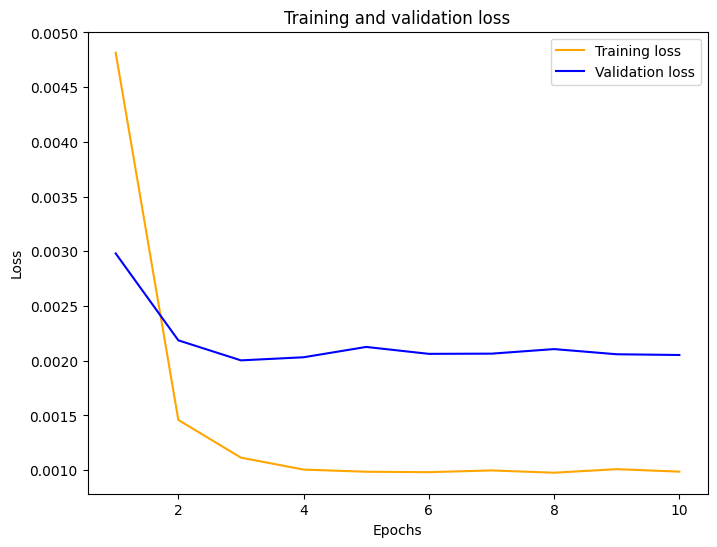

In [54]:
plot_curve(hist4)

In [55]:
predict_scaled4 = regressor4.predict(X_test4)
predict4 = sc4.inverse_transform(predict_scaled4)

95/95 [==============================] - 1s 4ms/step


In [56]:
train4 = train.copy()
test4 = test.copy()

In [57]:
train4.reset_index(inplace=True)
test4.reset_index(inplace=True)

In [58]:
test4['LSTM'] = predict4
test4

DateTime  cloud_cover      LSTM
0    2021-12-10 15:24:00        0.538  0.550389
1    2021-12-10 15:25:00        0.588  0.534287
2    2021-12-10 15:26:00        0.566  0.589989
3    2021-12-10 15:27:00        0.562  0.563542
4    2021-12-10 15:28:00        0.612  0.560521
...                  ...          ...       ...
3008 2021-12-16 13:58:00        0.168  0.167870
3009 2021-12-16 13:59:00        0.169  0.167774
3010 2021-12-16 14:00:00        0.147  0.168776
3011 2021-12-16 14:01:00        0.145  0.147491
3012 2021-12-16 14:02:00        0.144  0.144286

[3013 rows x 3 columns]

In [59]:
plot_test(train4,test4)

In [60]:
lstm_mse_error4 = mean_squared_error(test4['cloud_cover'], test4['LSTM'], squared=True)
print(f'MSE Error of lags 25 : {lstm_mse_error4}')

MSE Error of lags 25 : 0.002042290394225362


---

## Lag 30

In [61]:
# X_train, y_train, X_test and y_test
X_train5, y_train5, X_test5, y_test5, sc5 = Xtrain_ytrain(train,test,30)

X_train Shape : (12018, 30, 1)
y_train Shape : (12018, 1)
X_test Shape :  (3013, 30, 1)
y_test Shape :  (3013, 1)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



### Optimizer RMSprop batch size 32 first layer 50 second layer 50  

In [62]:
regressor5 = Sequential()
regressor5.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train5.shape[1], 1)))
regressor5.add(LSTM(units = 50))
regressor5.add(Dense(units = 1))
regressor5.compile(optimizer = 'RMSprop', loss = 'mean_squared_error')

In [63]:
hist5 = regressor5.fit(X_train5, y_train5, validation_data=(X_test5, y_test5), epochs = 10, batch_size = 32)

Epoch 1/10
376/376 [==============================] - 21s 40ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 2/10
376/376 [==============================] - 10s 27ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 3/10
376/376 [==============================] - 10s 27ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 4/10
376/376 [==============================] - 10s 27ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 5/10
376/376 [==============================] - 11s 28ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 6/10
376/376 [==============================] - 10s 27ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 7/10
376/376 [==============================] - 12s 31ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 8/10
376/376 [==============================] - 13s 33ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 9/10
376/376 [==============================] - 26s 70ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 10/10
376/376 [==============================] - 19s 50ms/step - loss: 0.001

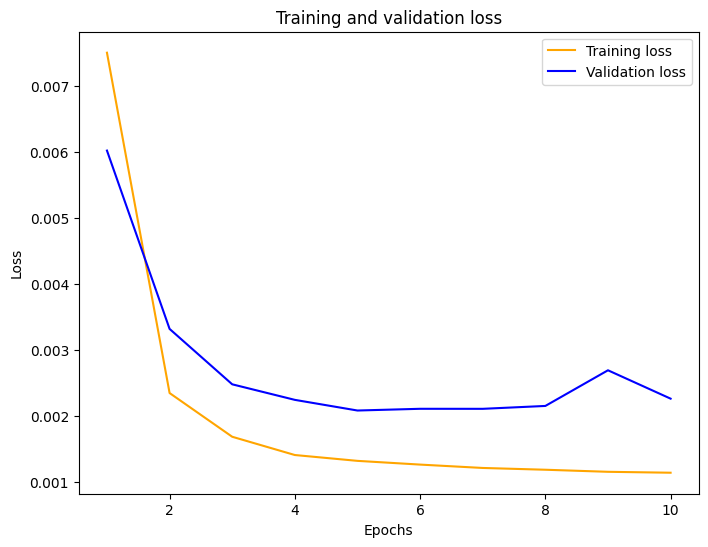

In [64]:
plot_curve(hist5)

In [65]:
predict_scaled5 = regressor5.predict(X_test5)
predict5 = sc5.inverse_transform(predict_scaled5)

95/95 [==============================] - 9s 27ms/step


In [66]:
train5 = train.copy()
test5 = test.copy()

In [67]:
train5.reset_index(inplace=True)
test5.reset_index(inplace=True)

In [68]:
test5['LSTM'] = predict5
test5

DateTime  cloud_cover      LSTM
0    2021-12-10 15:24:00        0.538  0.569543
1    2021-12-10 15:25:00        0.588  0.551715
2    2021-12-10 15:26:00        0.566  0.605183
3    2021-12-10 15:27:00        0.562  0.580027
4    2021-12-10 15:28:00        0.612  0.576512
...                  ...          ...       ...
3008 2021-12-16 13:58:00        0.168  0.171003
3009 2021-12-16 13:59:00        0.169  0.170930
3010 2021-12-16 14:00:00        0.147  0.171902
3011 2021-12-16 14:01:00        0.145  0.150810
3012 2021-12-16 14:02:00        0.144  0.147783

[3013 rows x 3 columns]

In [69]:
plot_test(train5,test5)

In [70]:
lstm_mse_error5 = mean_squared_error(test5['cloud_cover'], test5['LSTM'], squared=True)
print(f'MSE Error of lags 30 : {lstm_mse_error5}')

MSE Error of lags 30 : 0.0022504165470633936


---

In [71]:
regressor.save('model_lag5_train80per.h5')
regressor1.save('model_lag10_train80per.h5')
regressor2.save('model_lag15_train80per.h5')
regressor3.save('model_lag20_train80per.h5')
regressor4.save('model_lag25_train80per.h5')
regressor5.save('model_lag30_train80per.h5')

# one day

In [72]:
cloud_cover1 = pd.read_csv('../succeed-prophet/Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv',skipinitialspace = True)
cloud_cover1['Date'] = cloud_cover1[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
cloud_cover1.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)  
cloud_cover1 = cloud_cover1.rename(columns={"CloudCover":"cloud_cover"})
cloud_cover1 = cloud_cover1.groupby(['Date']).agg(cloud_cover=('cloud_cover','mean')).reset_index()    
cloud_cover1['Date'] = pd.to_datetime(cloud_cover1['Date'], format="%Y-%m-%d")
cloud_cover1.dropna(inplace=True)
cloud_cover1

Date  cloud_cover
0  2021-11-16     0.769193
1  2021-11-17     0.364608
2  2021-11-18     0.878172
3  2021-11-19     0.529353
4  2021-11-20     0.449684
5  2021-11-21     0.443777
6  2021-11-22     0.496665
7  2021-11-23     0.954683
8  2021-11-24     0.665824
9  2021-11-25     0.369516
10 2021-11-26     0.624922
11 2021-11-27     0.285787
12 2021-11-28     0.099198
13 2021-11-29     0.734920
14 2021-11-30     0.989415
15 2021-12-01     0.994706
16 2021-12-02     0.836681
17 2021-12-03     0.498022
18 2021-12-04     0.183476
19 2021-12-05     0.945286
20 2021-12-07     0.113274
21 2021-12-08     0.060397
22 2021-12-09     0.161857
23 2021-12-10     0.323322
24 2021-12-11     0.539296
25 2021-12-12     0.671356
26 2021-12-13     0.476423
27 2021-12-14     0.260594
28 2021-12-15     0.085025
29 2021-12-16     0.228007

# Train/Test Model

In [73]:
train8,test8 = train_test_split(cloud_cover1, train_size=0.8, shuffle=False)
print('Train Shape', train1.shape)
print('Test Shape', test1.shape)

Train Shape (12048, 2)
Test Shape (3013, 3)


In [74]:
train8 = train1.set_index('Date')
test1 = test1.set_index('Date')

sc1 = MinMaxScaler(feature_range = (0, 1))
training_set_scaled1 = sc1.fit_transform(train1)

X_train1 = []
y_train1 = []
for i in range(5, 24):
    X_train1.append(training_set_scaled1[i-5:i, 0])
    y_train1.append(training_set_scaled1[i, 0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], 1))

KeyError: "None of ['Date'] are in the columns"

In [ ]:
dataset_total1 = pd.concat((train1['cloud_cover'],test1['cloud_cover']), axis = 0)
inputs1 = dataset_total1[len(dataset_total1) - len(test1) - 5:].values
inputs1 = inputs1.reshape(-1,1)
inputs1 = sc1.transform(inputs1)
X_test1 = []
for i in range(5, 11):
    X_test1.append(inputs[i-5:i, 0])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1))

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



NameError: name 'inputs' is not defined

In [ ]:
regressor_d = Sequential()
regressor_d.add(LSTM(units = 50, activation='relu', input_shape = (X_train1.shape[1], 1)))
regressor_d.add(Dense(units = 1))
regressor_d.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
regressor_d.fit(X_train1, y_train1, epochs = 30, batch_size = 32)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.3125
Epoch 2/30
1/1 [==============================] - 0s 8ms/step - loss: 0.3057
Epoch 3/30
1/1 [==============================] - 0s 9ms/step - loss: 0.2989
Epoch 4/30
1/1 [==============================] - 0s 8ms/step - loss: 0.2922
Epoch 5/30
1/1 [==============================] - 0s 8ms/step - loss: 0.2855
Epoch 6/30
1/1 [==============================] - 0s 7ms/step - loss: 0.2788
Epoch 7/30
1/1 [==============================] - 0s 7ms/step - loss: 0.2722
Epoch 8/30
1/1 [==============================] - 0s 7ms/step - loss: 0.2657
Epoch 9/30
1/1 [==============================] - 0s 7ms/step - loss: 0.2593
Epoch 10/30
1/1 [==============================] - 0s 7ms/step - loss: 0.2530
Epoch 11/30
1/1 [==============================] - 0s 8ms/step - loss: 0.2468
Epoch 12/30
1/1 [==============================] - 0s 8ms/step - loss: 0.2406
Epoch 13/30
1/1 [==============================] - 0s 10ms/step - loss: 0.

In [ ]:
predict_scaled_d = regressor_d.predict(X_test1)
predict_scaled_d

1/1 [==============================] - 0s 225ms/step


array([[0.3062846 ],
       [0.31638327],
       [0.32527584],
       [0.33432806],
       [0.34558386],
       [0.3572604 ]], dtype=float32)

In [ ]:
predict_d = sc1.inverse_transform(predict_scaled_d)
predict_d

array([[0.34656155],
       [0.35599682],
       [0.36430523],
       [0.37276277],
       [0.38327917],
       [0.39418867]], dtype=float32)

In [ ]:
test1['LSTM'] = predict_d
test1

cloud_cover      LSTM
Date                             
2021-12-11     0.539296  0.346562
2021-12-12     0.671356  0.355997
2021-12-13     0.476423  0.364305
2021-12-14     0.260594  0.372763
2021-12-15     0.085025  0.383279
2021-12-16     0.228007  0.394189

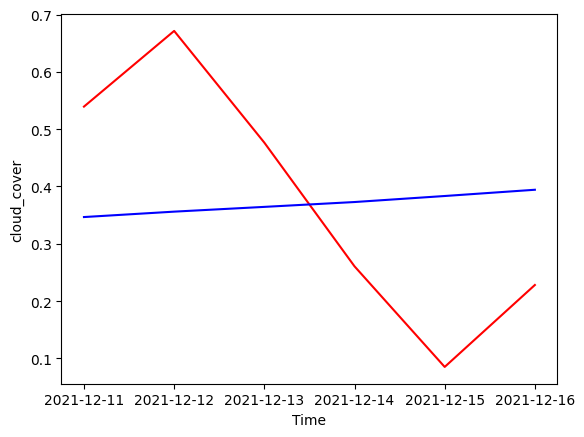

In [ ]:
plt.plot(test1['cloud_cover'], color = 'red', label = 'test')
plt.plot(test1['LSTM'], color = 'blue', label = 'predict')
plt.xlabel('Time')
plt.ylabel('cloud_cover')
plt.show()

In [ ]:
lstm_mse_error = mean_squared_error(test1['cloud_cover'], test1['LSTM'], squared=True)
lstm_rmse_error = mean_squared_error(test1['cloud_cover'], test1['LSTM'], squared=False)
lstm_mae_error = mean_absolute_error(test1['cloud_cover'], test1['LSTM'])
lstm_r2 = r2_score(test1['cloud_cover'], test1['LSTM'])
print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.046387037620043765
RMSE Error: 0.21537650201459713
MAE: 0.1994694150568058
r2_score: -0.1412780781639702
